In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

#find first row of each individual table with session query + .first()

first_row_m = session.query(Measurement).first()
print("First Row Measurement")
print("--------------")
print(first_row_m.__dict__)
print("--------")
first_row_s = session.query(Station).first()
print("First Row Station")
print("--------------")
print(first_row_s.__dict__)
print("--------")

#OR

#use Inspector
inspector = inspect(engine)
inspector.get_table_names()

inspector.get_columns('measurement')
col_m = inspector.get_columns('measurement')
print("Measurement Table")
print("--------------")
for column in col_m:
    print(column["name"],column["type"])


inspector.get_columns('station')
col_s = inspector.get_columns('station')
print( )
print("Station Table")
print("--------------")
for column in col_s:
    print(column["name"],column["type"])


First Row Measurement
--------------
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x117f184d0>, 'date': '2010-01-01', 'id': 1, 'tobs': 65.0, 'prcp': 0.08, 'station': 'USC00519397'}
--------
First Row Station
--------------
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x117f21250>, 'station': 'USC00519397', 'latitude': 21.2716, 'longitude': -157.8168, 'name': 'WAIKIKI 717.2, HI US', 'id': 1, 'elevation': 3.0}
--------
Measurement Table
--------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station Table
--------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [10]:
#exploring the sql table object Measurement
total_rows_m = session.query(func.count(Measurement.station)).all()
oldest_date = session.query(Measurement.date).order_by(Measurement.date).first()
newest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"The Measurement Table has {total_rows_m} rows. \n The oldest date"
      f"in this table is {oldest_date}. \n The newest date in this table"
      f" is {newest_date}")

newest_date_string=newest_date[0]

The Measurement Table has [(19550,)] rows. 
 The oldest datein this table is ('2010-01-01',). 
 The newest date in this table is ('2017-08-23',)


In [11]:
# Calculate the date 1 year ago from the last data point in the database

date_time_obj = dt.datetime.strptime(newest_date_string, '%Y-%m-%d')
print('Newest Date:', date_time_obj.date())

year_ago = date_time_obj - dt.timedelta(days=365)
print(f"Query Date: {year_ago.date()}")

year_ago_string = year_ago.strftime('%Y-%m-%d')
print(year_ago_string)

Newest Date: 2017-08-23
Query Date: 2016-08-23
2016-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

precip_data=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago_string).\
    order_by(Measurement.date).all()
print(precip_data) #comes back at a list of touples

[('2016-08-24', 0.08), ('2016-08-24', 2.15), ('2016-08-24', 2.28), ('2016-08-24', None), ('2016-08-24', 1.22), ('2016-08-24', 2.15), ('2016-08-24', 1.45), ('2016-08-25', 0.08), ('2016-08-25', 0.08), ('2016-08-25', 0.0), ('2016-08-25', 0.0), ('2016-08-25', 0.21), ('2016-08-25', 0.06), ('2016-08-25', 0.11), ('2016-08-26', 0.0), ('2016-08-26', 0.03), ('2016-08-26', 0.02), ('2016-08-26', 0.04), ('2016-08-26', 0.0), ('2016-08-26', 0.01), ('2016-08-27', 0.0), ('2016-08-27', 0.18), ('2016-08-27', 0.02), ('2016-08-27', 0.0), ('2016-08-27', 0.12), ('2016-08-27', None), ('2016-08-28', 0.01), ('2016-08-28', 0.14), ('2016-08-28', 0.14), ('2016-08-28', 0.14), ('2016-08-28', 0.6), ('2016-08-28', 2.07), ('2016-08-29', 0.0), ('2016-08-29', 0.17), ('2016-08-29', 0.04), ('2016-08-29', None), ('2016-08-29', 0.0), ('2016-08-29', 0.35), ('2016-08-29', 0.9), ('2016-08-30', 0.0), ('2016-08-30', 0.0), ('2016-08-30', 0.02), ('2016-08-30', 0.0), ('2016-08-30', 0.0), ('2016-08-30', 0.05), ('2016-08-31', 0.13), (

In [13]:
# If we wanted to plot using Matplotlib, we would need to:
# Convert list of tuples (precip_data) into 2 normal lists using list comprehension and then plot

dates = [result[0] for result in precip_data]
precipitation = [result[1] for result in precip_data]


precip_dictionary = dict(zip(dates,precipitation))

#print(dates)
#print("---------")
#print(precipitation)

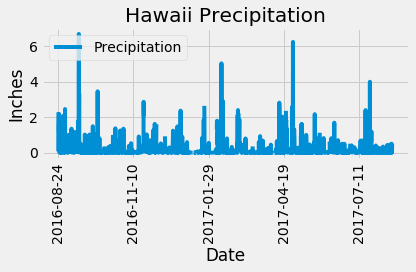

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# precip_data is a dictionary of touples. Pandas df's can use touples 

df = pd.DataFrame(precip_data, columns=['Date','Precipitation'])
df.set_index('Date', inplace=True)
df.head()

# Sort the dataframe by date
sorted_values = df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data

sorted_values.plot(title="Hawaii Precipitation", rot=90)
plt.ylabel("Inches")
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

sorted_values.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(func.count(Station.station)).all()
print(available_stations)

[(9,)]


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations_list = []
for station in active_stations:
    active_stations_list.append(station[0])
print(active_stations_list)
#print(active_stations)
most_active_station=active_stations[0][0]
#print(most_active_station)

['USC00519281', 'USC00519397', 'USC00513117', 'USC00519523', 'USC00516128', 'USC00514830', 'USC00511918', 'USC00517948', 'USC00518838']


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(Measurement.station,Measurement.tobs).filter(Measurement.station == most_active_station).order_by(Measurement.tobs).first()
print(f"The lowest temperature recorded at station {most_active_station} is {lowest_temp[1]}")

highest_temp = session.query(Measurement.station,Measurement.tobs).filter(Measurement.station == most_active_station).order_by(Measurement.tobs.desc()).first()
print(f"The highest temperature recorded at station {most_active_station} is {highest_temp[1]}")

avg_temp = session.query(Measurement.station,func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"The average temperature recorded at station {most_active_station} is {avg_temp[0][1]}")

    

The lowest temperature recorded at station USC00519281 is 54.0
The highest temperature recorded at station USC00519281 is 85.0
The average temperature recorded at station USC00519281 is 71.66378066378067


In [19]:
tobs_route= session.query(Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date > year_ago_string).all()

tobs_route

[(77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (70.0),
 (68.0),
 (69.0),
 (69.0),
 (66.0),
 

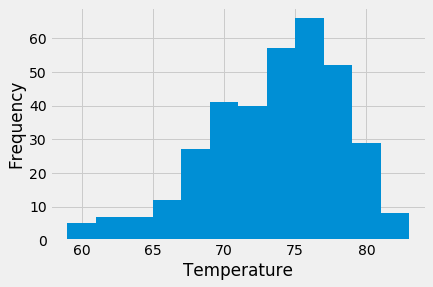

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histo_query = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date > year_ago_string).all()

histo_temps = [result[0] for result in histo_query]
#print(histo_temps)
x = histo_temps
plt.hist(x, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.show()


## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
